# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os, sys

%matplotlib inline

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization, add, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint

## Data Preparation

In [6]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

In [7]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
tst_comorb = pd.read_csv(path+'cohorts/ami/comorb_tst.csv')

train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
tst_df = ami_index[ami_index['KEY_NRD'].isin(tst_comorb['KEY_NRD'])]

N_train = len(train_df)
N_tst = len(tst_df)
all_df = pd.concat([train_df, tst_df])

del(ami_index, train_comorb, tst_comorb)

In [8]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)

train_df = pd.concat([trn_df, val_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [9]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')

In [151]:
rare_cutpoint = 1
code_freq = DX_series.value_counts()
rare_code = code_freq[code_freq<rare_cutpoint].index
DX_series.loc[DX_series.isin(rare_code)] = 'rare'

In [10]:
DX_series = DX_series.astype('category')
DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_int_cat = list(range(n_DX_cat)[1:]) +[0]
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [11]:
n_DX_cat

5458

In [11]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

In [12]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## LSTM with Raw ICD9 codes

In [14]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

In [145]:
DX_df = train_df[DXs]
DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(rare_code)] = 'rare'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values
DX_mat_trn = DX_df.values[:N_trn, ]
DX_mat_val = DX_df.values[N_trn:, ]

In [20]:
DX_ohe = np.zeros((len(train_df), n_DX_cat))

for j in range(DX_mat.shape[0]):
    for i in range(DX_mat.shape[1]):
        DX_ohe[j, DX_mat[j, i]] = 1

DX_ohe_trn = DX_ohe[:N_trn, ]
DX_ohe_val = DX_ohe[N_trn:, ]

In [21]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

In [22]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [23]:
DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

In [24]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

### Model Building with Embedding

In [129]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [146]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=n_DX_cat, output_dim=DX_embed_dim, input_length=N_DX)(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
#DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False)(DX_embed)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 29, 50)       266400      input_17[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 1)         869         input_20[0][0]                   
__________________________________________________________________________________________________
input_18 (

In [147]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [148]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_lstm_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_lstm_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [149]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [150]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_mat_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
145667/145667 [==============================] - 3s 23us/step - loss: 1.3184 - acc: 0.6007 - val_loss: 0.6395 - val_acc: 0.5991
AUC: 0.6896

Epoch 2/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2609 - acc: 0.6178 - val_loss: 0.6346 - val_acc: 0.6035
AUC: 0.6955

Epoch 3/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2497 - acc: 0.6205 - val_loss: 0.6506 - val_acc: 0.5970
AUC: 0.6957

Epoch 4/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2427 - acc: 0.6249 - val_loss: 0.6191 - val_acc: 0.6244
AUC: 0.6966

Epoch 5/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2401 - acc: 0.6250 - val_loss: 0.5905 - val_acc: 0.6412
AUC: 0.6957

Epoch 6/20
145667/145667 [==============================] - 2s 15us/step - loss: 1.2357 - acc: 0.6234 - val_loss: 0.6054 - val_acc: 0.6371
AUC: 0.6947

Epoch 7/20
145667/145667 [===========

### Model testing

In [151]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(rare_code)] = 'rare'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

In [34]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [35]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [36]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [152]:
model.load_weights(model_path+'ami_icd9_lstm_auc1.h5')

In [153]:
y = model.predict([demo_mat_tst, DX1_mat_tst, DX_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 58us/step


{0: 0.7063960981175992}

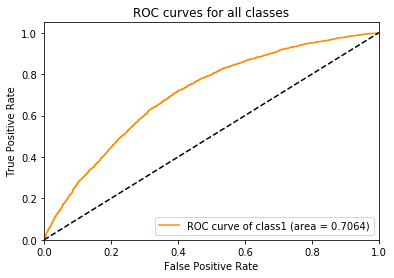

In [155]:
plot_roc(y_pred, y_true)

## Multi-Level CCS Codes

### Define the parent matrix

Read the ICD9 CCS multi-level category dictionary file. 

In [13]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

In [14]:
multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [159]:
multi_ccs.shape

(15072, 9)

In [23]:
multi_ccs.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

Create one list to store all possible ICD9 code and their CCS multi-level in a list. Creat two dataframe to store the parent of each code and the indices of the parent. 

In [15]:
ami_ccs = multi_ccs.loc[multi_ccs.ICD9CM_CODE.isin(DX_cat)]

In [16]:
ami_ccs.shape

(5455, 5)

In [16]:
ccs_cat = pd.concat([ami_ccs.CCS_LVL1, ami_ccs.CCS_LVL2, ami_ccs.CCS_LVL3, ami_ccs.CCS_LVL4]).astype('category').cat.categories

In [24]:
len(ccs_cat)

643

In [17]:
all_codes = [DX_cat[-1]]+list(DX_cat[:-1]) + list(ccs_cat[1:])

In [19]:
len(all_codes)

6100

In [18]:
ami_ccs = ami_ccs.set_index(ami_ccs.ICD9CM_CODE, drop=True).drop(['ICD9CM_CODE'], axis=1)

ami_ccs['finest_non_empty'] = ami_ccs.CCS_LVL4
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL3[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL2[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL1[ami_ccs.finest_non_empty == '']

DX_parent = ami_ccs[['finest_non_empty']]

DX_parent.columns = ['parent_code']

DX_parent = DX_parent.assign(parent_index=DX_parent.parent_code.apply(lambda x:all_codes.index(x)).values)

DX_parent = DX_parent.append(pd.DataFrame(index=['incn', 'invl', 'missing'], data=dict(parent_code = ['NA']*3, 
                                                                                       parent_index=[-1]*3)))

In [19]:
CCS_parent = pd.DataFrame(dict(CCS_code=ccs_cat[1:]))

CCS_parent = CCS_parent.assign(parent_code=CCS_parent.CCS_code.apply(lambda x:'.'.join(x.split('.')[:-1])))

def get_CCS_ind(code):
    try:
        ind = all_codes.index(code)
    except ValueError:
        ind = -1
    return ind
CCS_parent = CCS_parent.assign(parent_index=CCS_parent.parent_code.apply(get_CCS_ind).values)

CCS_parent = CCS_parent.set_index(CCS_parent.CCS_code, drop=True).drop(['CCS_code'], axis=1)

In [111]:
CCS_parent.head()

,parent_code,parent_index
CCS_code,,
1,,-1
1.1,1,5458
1.1.1,1.1,5459
1.1.2,1.1,5459
1.1.2.1,1.1.2,5461


In [112]:
DX_parent.head()

,parent_code,parent_index
ICD9CM_CODE,,
01120,1.1.1,5460
01180,1.1.1,5460
01190,1.1.1,5460
01191,1.1.1,5460
01193,1.1.1,5460


In [20]:
parent_df = pd.concat([DX_parent, CCS_parent], axis=0)

In [21]:
parent_mat = np.identity(len(all_codes))

In [22]:
for i, c in enumerate(all_codes):
    parent_ind = parent_df.loc[c, 'parent_index']
    if not parent_ind == -1:
        parent_mat[i, parent_ind] = -1

In [23]:
no_parent = np.where(parent_mat.sum(axis=1)>0)[0]

In [24]:
np.array(all_codes)[no_parent]

array(['missing', 'incn', 'invl', '1', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U9')

In [25]:
parent_mat = parent_mat[parent_mat.sum(axis=1)==0, :]

In [26]:
np.save(path+'cohorts/ami/parent_mat.npy', parent_mat)

### Data Formatting

In [21]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

In [22]:
DX_df = train_df[DXs]
DX_df = DX_df.fillna('missing')

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values
DX_mat_trn = DX_df.values[:N_trn, ]
DX_mat_val = DX_df.values[N_trn:, ]

In [23]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

demo_mat_trn = demo_mat[:N_trn, ]
demo_mat_val = demo_mat[N_trn:, ]

In [24]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [25]:
DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

DX1_mat_trn = DX1_mat[:N_trn, ]
DX1_mat_val = DX1_mat[N_trn:, ]

In [26]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [27]:
DX_embed_dim = 20
hosp_embed_dim = 1

In [28]:
parent_mat = np.load(path+'cohorts/ami/parent_mat.npy')

In [29]:
pmat = K.constant(value=parent_mat, dtype=K.floatx(), name='parent_mat')

In [30]:
def ccs_reg(embed_mat):
    diff = K.dot(pmat, embed_mat) #difference between each code and its parent
    return 0.5*K.sum(K.square(diff))

In [36]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=len(all_codes), output_dim=DX_embed_dim, input_length=N_DX, mask_zero=True,
                     embeddings_regularizer=ccs_reg, name='DX_embed')(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
#DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
DX_feature = LSTM(DX_embed_dim, return_sequences=False)(DX_embed)

In [49]:
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=len(all_codes), output_dim=DX_embed_dim, input_length=N_DX,
                     embeddings_regularizer=ccs_reg, name='DX_embed')(input_DX)

#DX_out, _, DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False, return_state=True)(DX_embed)
#DX_feature = Lambda(lambda x: K.sum(x, axis=1))(DX_embed)
DX_feature = CuDNNLSTM(DX_embed_dim, return_sequences=False)(DX_embed)

In [50]:
input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

#x = Dense(64, activation='relu')(merged)
#x = Dense(32, activation='relu')(x)
#x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [41]:
model.layers[2].weights

[<tf.Variable 'DX_embed/embeddings:0' shape=(6100, 50) dtype=float32_ref>]

In [51]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_ccs_lstm_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_ccs_lstm_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=1.e-7)
#earlystop = EarlyStopping(monitor='val_loss', patience=40)

In [36]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [53]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_mat_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=200, callbacks=[checkpoint, auccheckpoint, reduce_lr], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_mat_val, hosp_array_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/200
145667/145667 [==============================] - 9s 62us/step - loss: 11.0536 - acc: 0.5688 - val_loss: 0.6880 - val_acc: 0.6178
AUC: 0.6695

Epoch 2/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.3303 - acc: 0.5935 - val_loss: 0.6998 - val_acc: 0.5685
AUC: 0.6884

Epoch 3/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2952 - acc: 0.6150 - val_loss: 0.7701 - val_acc: 0.4875
AUC: 0.6977

Epoch 4/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2788 - acc: 0.6156 - val_loss: 0.6869 - val_acc: 0.5843
AUC: 0.7026

Epoch 5/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2722 - acc: 0.6195 - val_loss: 0.6681 - val_acc: 0.6033
AUC: 0.7069

Epoch 6/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2644 - acc: 0.6260 - val_loss: 0.6546 - val_acc: 0.6100
AUC: 0.7061

Epoch 7/200
145667/145667 [===

145667/145667 [==============================] - 2s 16us/step - loss: 1.2261 - acc: 0.6434 - val_loss: 0.6326 - val_acc: 0.6354
AUC: 0.7080

Epoch 55/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2261 - acc: 0.6425 - val_loss: 0.6074 - val_acc: 0.6593
AUC: 0.7076

Epoch 56/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2256 - acc: 0.6459 - val_loss: 0.6617 - val_acc: 0.6082
AUC: 0.7064

Epoch 57/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2253 - acc: 0.6429 - val_loss: 0.6467 - val_acc: 0.6230
AUC: 0.7070

Epoch 58/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2254 - acc: 0.6434 - val_loss: 0.6407 - val_acc: 0.6280
AUC: 0.7064

Epoch 59/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2248 - acc: 0.6440 - val_loss: 0.6519 - val_acc: 0.6186
AUC: 0.7055

Epoch 60/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2245

145667/145667 [==============================] - 2s 15us/step - loss: 1.2085 - acc: 0.6517 - val_loss: 0.6389 - val_acc: 0.6327
AUC: 0.7029

Epoch 108/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2084 - acc: 0.6511 - val_loss: 0.6228 - val_acc: 0.6460
AUC: 0.7029

Epoch 109/200
145667/145667 [==============================] - 2s 16us/step - loss: 1.2083 - acc: 0.6504 - val_loss: 0.6072 - val_acc: 0.6594
AUC: 0.7028

Epoch 110/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2082 - acc: 0.6519 - val_loss: 0.6372 - val_acc: 0.6355
AUC: 0.7017

Epoch 111/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.2084 - acc: 0.6510 - val_loss: 0.6114 - val_acc: 0.6563
AUC: 0.7029

Epoch 112/200
145667/145667 [==============================] - 2s 16us/step - loss: 1.2080 - acc: 0.6529 - val_loss: 0.6278 - val_acc: 0.6438
AUC: 0.7024

Epoch 113/200
145667/145667 [==============================] - 2s 15us/step - loss: 

145667/145667 [==============================] - 2s 16us/step - loss: 1.1936 - acc: 0.6558 - val_loss: 0.6132 - val_acc: 0.6575
AUC: 0.6963

Epoch 161/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.1934 - acc: 0.6565 - val_loss: 0.5942 - val_acc: 0.6718
AUC: 0.6977

Epoch 162/200
145667/145667 [==============================] - 2s 16us/step - loss: 1.1935 - acc: 0.6571 - val_loss: 0.6022 - val_acc: 0.6655
AUC: 0.6971

Epoch 163/200
145667/145667 [==============================] - 2s 16us/step - loss: 1.1930 - acc: 0.6582 - val_loss: 0.6253 - val_acc: 0.6472
AUC: 0.6958

Epoch 164/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.1931 - acc: 0.6577 - val_loss: 0.6088 - val_acc: 0.6604
AUC: 0.6965

Epoch 165/200
145667/145667 [==============================] - 2s 15us/step - loss: 1.1927 - acc: 0.6571 - val_loss: 0.6300 - val_acc: 0.6430
AUC: 0.6953

Epoch 166/200
145667/145667 [==============================] - 2s 15us/step - loss: 

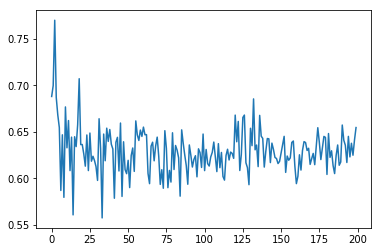

In [62]:
plt.plot(hist.history['val_loss'])

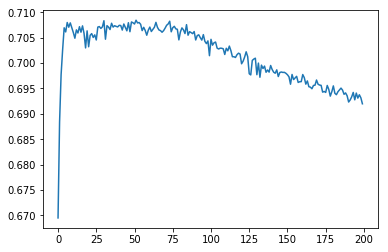

In [60]:
plt.plot(auccheckpoint.auc_history)

### Model testing

In [65]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

In [66]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [67]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [68]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [63]:
model.load_weights(model_path+'ami_ccs_lstm_auc1.h5')

In [69]:
y = model.predict([demo_mat_tst, DX1_mat_tst, DX_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 62us/step


{0: 0.7025506525367047}

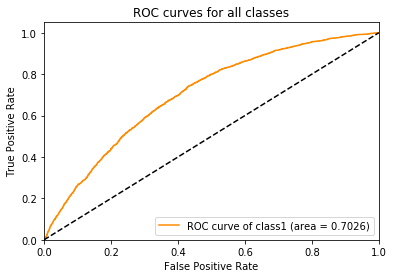

In [70]:
plot_roc(y_pred, y_true)

In [71]:
embed_trained = model.layers[2]

embed_mat = embed_trained.get_weights()[0]

In [72]:
np.linalg.norm(embed_mat, axis=1, ord=2)[:20]

array([0.13445328, 0.01330469, 0.01692051, 0.01324792, 0.01288445,
       0.01326387, 0.0132484 , 0.01324365, 0.01305246, 0.01320876,
       0.01324838, 0.013367  , 0.01326561, 0.0132235 , 0.0132535 ,
       0.01358849, 0.01516505, 0.01328224, 0.01323698, 0.01324947],
      dtype=float32)

In [120]:
np.linalg.norm(np.dot(parent_mat, embed_mat), axis=1, ord=2)[:20]

array([1.67420201e-02, 1.25085167e-03, 3.88638256e-04, 1.11788415e-02,
       9.17833277e-03, 5.80740744e-03, 1.52295803e-03, 3.01085294e-02,
       6.11861637e-03, 8.90269510e-03, 2.30148840e-02, 5.32340409e-04,
       5.70435590e-03, 2.60904864e-03, 5.05236697e-03, 5.88568662e-02,
       1.29949138e-02, 8.28027064e-05, 9.94104499e-03, 3.17214810e-03])

In [73]:
from sklearn import decomposition, manifold

In [74]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [75]:
embed_tsne = tsne.fit_transform(embed_mat[1:(n_DX_cat-2),:])

In [76]:
ccs_lvl1 = [ami_ccs.loc[c, 'CCS_LVL1'] for c in all_codes[1:(n_DX_cat-2)]]

fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in all_codes[1:(n_DX_cat-2)]]

plot_df = pd.DataFrame(dict(x=embed_tsne[:, 0], y=embed_tsne[:, 1], lvl1=ccs_lvl1, fine_group=fine_group))

In [99]:
for n in list(gkey)[10:]:
    print(n, groups.get_group(n).shape)

11 (16, 4)
14 (162, 4)
16 (812, 4)
5 (333, 4)
3 (307, 4)
7 (463, 4)
12 (128, 4)
18 (206, 4)


In [ ]:
groups = plot_df.groupby('lvl1')

In [88]:
gkey = groups.groups.keys()

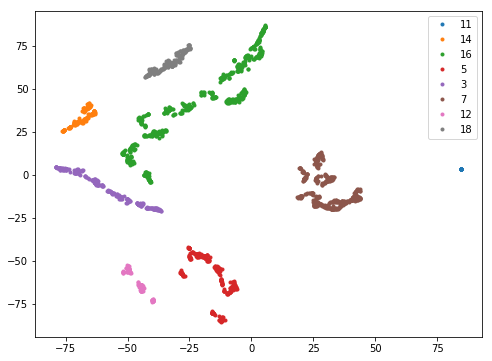

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
for name in list(gkey)[10:]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [78]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:20].index

plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

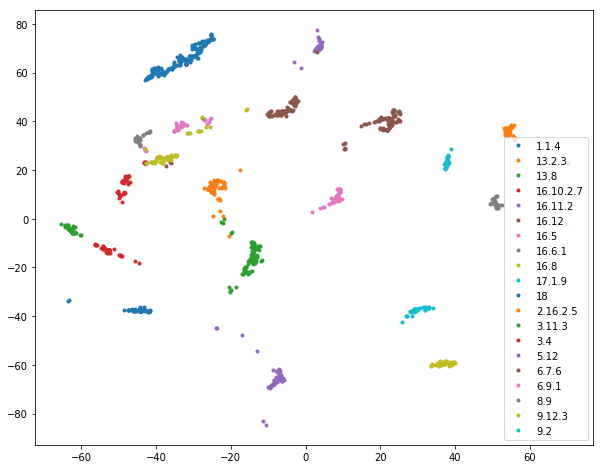

In [79]:
groups = plot_subdf.groupby('fine_group')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [108]:
top_fine_cat

Index(['18', '13.8', '6.7.6', '16.12', '13.2.3', '16.8', '5.12', '6.9.1',
       '16.5', '2.16.2.5', '9.12.3', '16.10.2.7', '1.1.4', '9.2', '3.11.3',
       '3.4', '16.6.1', '17.1.9', '8.9', '10.1.8.3'],
      dtype='object')

### Backups

### Model Building with OHE

In [20]:
DX_embed_dim = 50
hosp_embed_dim = 1

In [55]:
input_DX = Input(shape = (n_DX_cat,))
DX_feature = Dense(DX_embed_dim, use_bias=False)(input_DX)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_feature, hosp_embed], axis=1)

x = Dense(128, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [56]:
DX_feature.shape

TensorShape([Dimension(None), Dimension(50)])

In [58]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_icd9_ohe_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_icd9_ohe_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [60]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [61]:
hist = model.fit([demo_mat_trn, DX1_mat_trn, DX_ohe_trn, hosp_array_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat_val, DX1_mat_val, DX_ohe_val, hosp_array_val], Y_val], 
                verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
 - 7s - loss: 1.3245 - acc: 0.5939 - val_loss: 0.6438 - val_acc: 0.6399
AUC: 0.6854

Epoch 2/20
 - 9s - loss: 1.2781 - acc: 0.6356 - val_loss: 0.6329 - val_acc: 0.6380
AUC: 0.6898

Epoch 3/20
 - 9s - loss: 1.2583 - acc: 0.6404 - val_loss: 0.6276 - val_acc: 0.6399
AUC: 0.6901

Epoch 4/20
 - 9s - loss: 1.2450 - acc: 0.6460 - val_loss: 0.6301 - val_acc: 0.6279
AUC: 0.6871

Epoch 5/20
 - 9s - loss: 1.2293 - acc: 0.6470 - val_loss: 0.6398 - val_acc: 0.6230
AUC: 0.6841

Epoch 6/20
 - 9s - loss: 1.2162 - acc: 0.6539 - val_loss: 0.6214 - val_acc: 0.6377
AUC: 0.6814

Epoch 7/20
 - 9s - loss: 1.2016 - acc: 0.6574 - val_loss: 0.6104 - val_acc: 0.6439
AUC: 0.6778

Epoch 8/20
 - 9s - loss: 1.1875 - acc: 0.6590 - val_loss: 0.6120 - val_acc: 0.6417
AUC: 0.6747

Epoch 9/20
 - 9s - loss: 1.1727 - acc: 0.6650 - val_loss: 0.6097 - val_acc: 0.6387
AUC: 0.6750

Epoch 10/20
 - 9s - loss: 1.1610 - acc: 0.6660 - val_loss: 0.6189 - val_acc: 0.6329
A